In [1]:
!pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 855.8/855.8 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torchgeo
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
nir_img = r"/content/drive/MyDrive/Colab Notebooks/mastarbeit/in_data/2024350_Mosaik_NIR.tif"
rgb_img = r"/content/drive/MyDrive/Colab Notebooks/mastarbeit/in_data/2024350_Mosaik_RGB.tif"
mask_img = r"/content/drive/MyDrive/Colab Notebooks/mastarbeit/out_data/final_lulc_train_remapped_2.tif"

In [11]:
from torchgeo.datasets import IntersectionDataset
from torchgeo.datasets import RasterDataset, roi_split
from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, IntersectionDataset, stack_samples




In [ ]:
import torchgeo
from torchgeo.datasets import (
    IntersectionDataset,
    RasterDataset,
    BoundingBox,
    stack_samples
)
from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader


# 1. Full Dataset
rgb_data = RasterDataset(paths=rgb_img, crs=31256)
nir_data = RasterDataset(paths=nir_img, crs=31256)
mask_dataset = RasterDataset(paths=mask_img, crs=31256)
mask_dataset.is_image = False
rgb_nir_data = IntersectionDataset(rgb_data, nir_data)
dataset = IntersectionDataset(rgb_nir_data, mask_dataset)

# 2. Full Region of Interest (ROI)
minx = -101193.4376
maxx = -25073.1548
miny = 172175.6434
maxy = 225951.9085
mint, maxt = 0, 0
custom_roi = BoundingBox(minx, maxx, miny, maxy, mint, maxt)

# --- NEW: Splitting the ROI for Train/Val/Test ---

# 1. Define split percentages and patch size/count
train_pct = 0.70
val_pct = 0.15
# test_pct is implicitly 0.15

patch_size = 512
train_samples = 5000 # Number of patches in one epoch
val_samples = 1000
test_samples = 50
# train_samples = 50 # Number of patches in one epoch
# val_samples = 15
# test_samples = 15


# 2. Calculate the spatial split boundaries
# We'll split vertically along the x-axis.
width = custom_roi.maxx - custom_roi.minx
train_val_split_x = custom_roi.minx + width * train_pct
val_test_split_x = train_val_split_x + width * val_pct

# 3. Create three new, non-overlapping BoundingBox objects
train_roi = BoundingBox(
    minx=custom_roi.minx,
    maxx=train_val_split_x,
    miny=custom_roi.miny,
    maxy=custom_roi.maxy,
    mint=mint,
    maxt=maxt
)

val_roi = BoundingBox(
    minx=train_val_split_x,
    maxx=val_test_split_x,
    miny=custom_roi.miny,
    maxy=custom_roi.maxy,
    mint=mint,
    maxt=maxt
)

test_roi = BoundingBox(
    minx=val_test_split_x,
    maxx=custom_roi.maxx,
    miny=custom_roi.miny,
    maxy=custom_roi.maxy,
    mint=mint,
    maxt=maxt
)

print("--- Spatial Split ROIs ---")
print(f"Train ROI: {train_roi}")
print(f"Val ROI:   {val_roi}")
print(f"Test ROI:  {test_roi}")
print("--------------------------\n")


# 4. Create a unique Sampler and DataLoader for each split
# Note: They all use the SAME 'dataset' object, but their 'roi' restricts them.
batch_size = 4

# Training DataLoader
train_sampler = RandomGeoSampler(dataset, size=patch_size, length=train_samples, roi=train_roi)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=stack_samples)

# Validation DataLoader
val_sampler = RandomGeoSampler(dataset, size=patch_size, length=val_samples, roi=val_roi)
val_dataloader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size, collate_fn=stack_samples)

# Testing DataLoader
test_sampler = RandomGeoSampler(dataset, size=patch_size, length=test_samples, roi=test_roi)
test_dataloader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size, collate_fn=stack_samples)

print("DataLoaders created successfully!")
print(f"Train Dataloader: {len(train_dataloader)} batches of size {batch_size}")
print(f"Val Dataloader:   {len(val_dataloader)} batches of size {batch_size}")
print(f"Test Dataloader:  {len(test_dataloader)} batches of size {batch_size}")

--- Spatial Split ROIs ---
Train ROI: BoundingBox(minx=-101193.4376, maxx=-47909.23964000001, miny=172175.6434, maxy=225951.9085, mint=0, maxt=0)
Val ROI:   BoundingBox(minx=-47909.23964000001, maxx=-36491.19722000001, miny=172175.6434, maxy=225951.9085, mint=0, maxt=0)
Test ROI:  BoundingBox(minx=-36491.19722000001, maxx=-25073.1548, miny=172175.6434, maxy=225951.9085, mint=0, maxt=0)
--------------------------

DataLoaders created successfully!
Train Dataloader: 1250 batches of size 4
Val Dataloader:   250 batches of size 4
Test Dataloader:  13 batches of size 4


In [13]:
import torch

In [14]:

# Hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")
for i, sample in enumerate(train_dataloader):
    images = sample['image'].to(device).float()
    images = images / 255.0 # Assuming uint8 input, adjust if necessary+
    masks = sample['mask'].to(device) # Shape: [B, 1, H, W]
    if masks.dim() == 4 and masks.shape[1] == 1:
        masks = masks.squeeze(1)
    masks_long = masks.long()

    print(masks.size())
    print(images.size())
    break

Using device: cuda
torch.Size([4, 512, 512])
torch.Size([4, 4, 512, 512])


In [15]:
import numpy as np
import os

In [ ]:
def create_class_mapper():
    """
    Creates a vectorized class mapper using a NumPy array as a lookup table,
    with special handling for out-of-bounds indices like -1.
    """
    # Define the mapping for non-negative class IDs.
    # We will handle -1 separately.
    mapping_dict = {
        # New Class ID: [List of Old Class IDs]
        0: [0],                                     # Unknown/Background
        1: [1, 2, 3, 4, 26],                        # Buildings
        2: [5, 6, 7],                               # Roads
        3: [10, 22],                                # Trees
        4: [8, 9, 20, 25, 27, 28, 29, 30, 31, 32, 34], # 'Artificial' ground other than road
        5: [11, 12, 14, 21, 23, 24, 33, 35, 36, 37, 38, 39], # 'Natural' ground covered by vegetation
        6: [18, 19],                                # Water
        7: [13, 15, 16, 17],                        # Bare Ground
    }

    # Create a lookup array for fast, vectorized mapping for old IDs 0-39.
    lookup_table = np.zeros(40, dtype=np.int32)
    for new_id, old_ids in mapping_dict.items():
        # Ensure we only use valid indices for the lookup table
        valid_old_ids = [i for i in old_ids if i >= 0]
        if valid_old_ids:
            lookup_table[valid_old_ids] = new_id

    def map_classes_vectorized(matrix: np.ndarray) -> np.ndarray:
        """
        Maps class IDs using the pre-computed lookup table for valid indices
        and handles special cases like -1 separately.
        """
        # Create an output array, initialized with a value that indicates "unmapped".
        # We'll use 0 as the default and then explicitly set the -1 cases.
        result = np.zeros_like(matrix, dtype=np.int32)

        # Create a mask for values that are within the lookup table's bounds (0-39)
        valid_mask = (matrix >= 0) & (matrix < len(lookup_table))

        # Apply the fast lookup table only to the valid values
        result[valid_mask] = lookup_table[matrix[valid_mask]]
        result[matrix == -1] = -1

        return result

    return map_classes_vectorized
# --- Example Usage ---

# 1. Create the mapper function once in application's setup phase.
mapper = create_class_mapper()

Starting Inference and Visualization...
(array([10]), array([262144]))
colored_mask shape: (512, 512, 4)
img_to_plot shape: (512, 512, 3)
(array([3], dtype=int32), array([262144]))
colored_mask shape: (512, 512, 4)


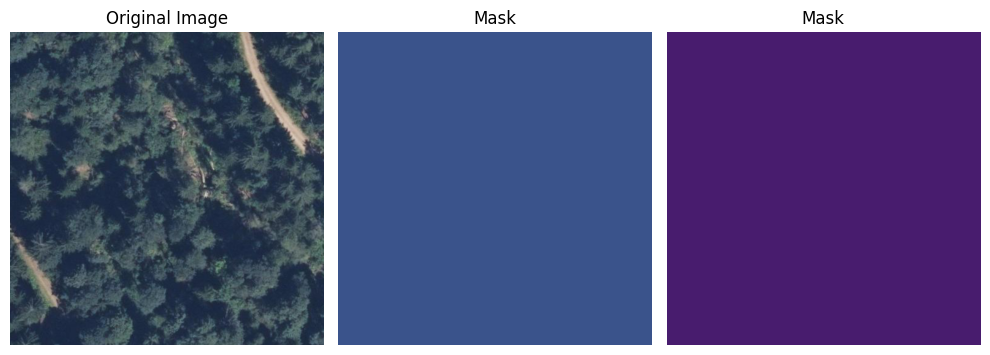

(array([-1, 10, 11, 19, 21, 35, 36]), array([ 18416, 143032,      8,    278,   8372,  91855,    183]))
colored_mask shape: (512, 512, 4)
img_to_plot shape: (512, 512, 3)
(array([-1,  3,  5,  6], dtype=int32), array([ 18416, 143032, 100418,    278]))
colored_mask shape: (512, 512, 4)


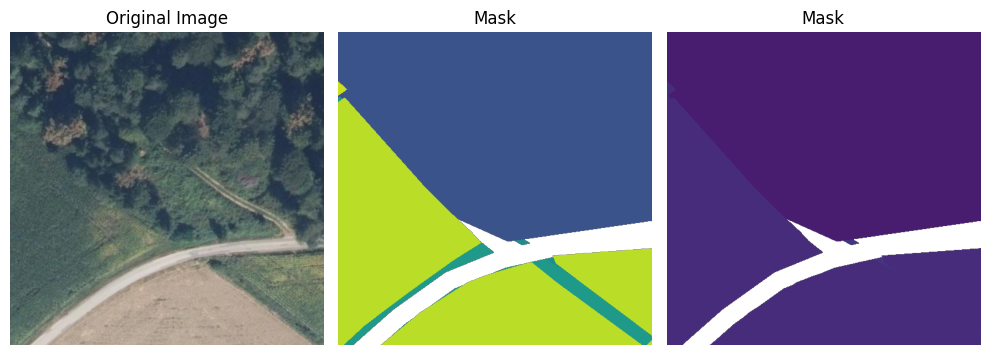

(array([-1, 35, 36]), array([ 37241, 166462,  58441]))
colored_mask shape: (512, 512, 4)
img_to_plot shape: (512, 512, 3)
(array([-1,  5], dtype=int32), array([ 37241, 224903]))
colored_mask shape: (512, 512, 4)


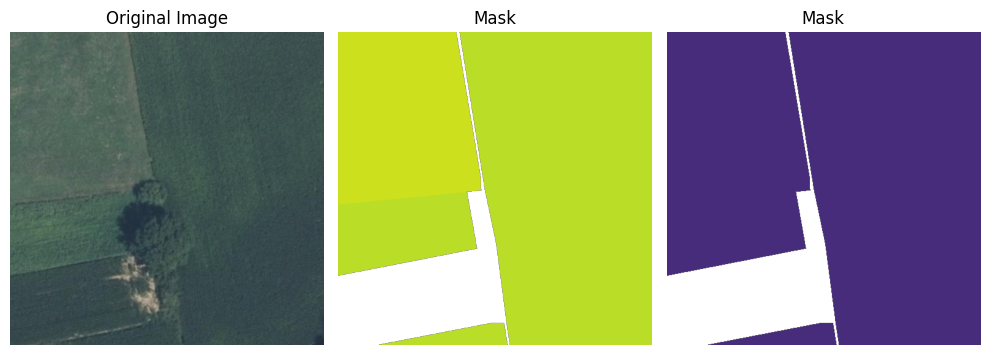

(array([-1, 10]), array([226288,  35856]))
colored_mask shape: (512, 512, 4)
img_to_plot shape: (512, 512, 3)
(array([-1,  3], dtype=int32), array([226288,  35856]))
colored_mask shape: (512, 512, 4)


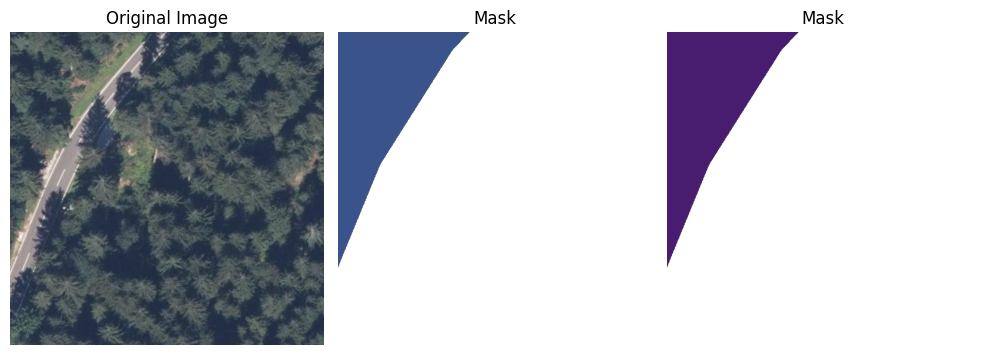

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch 

print("Starting Inference and Visualization...")
num_actual_classes = 40
ignore_index_value = 0
# Define a color map for classes 
colors = plt.cm.viridis(np.linspace(0, 1, num_actual_classes))
# Add a color for the ignore index (e.g., black)
ignore_color = [0, 0, 0, 1] # RGBA for black
cmap = np.vstack([colors, ignore_color])


for j in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Plot the original image
    img_to_plot = images[j].cpu().permute(1, 2, 0).numpy() # Transpose to HWC
    img_to_plot = img_to_plot[:, :, 0:3]
    axes[0].imshow(img_to_plot)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the predicted mask with color map
    mask_to_plot = masks_long[j].cpu().numpy() # Move mask to CPU and convert to numpy
    # Create a color image from the indices
    colored_mask = np.zeros((mask_to_plot.shape[0], mask_to_plot.shape[1], 4))
    for class_index in range(num_actual_classes):
        colored_mask[mask_to_plot == class_index] = cmap[class_index]
    colored_mask[mask_to_plot == ignore_index_value] = cmap[-1] # Color for ignore index

    axes[1].imshow(colored_mask)
    axes[1].set_title("Mask")
    axes[1].axis('off')
    print(np.unique(mask_to_plot, return_counts=True))
    print("colored_mask shape:", colored_mask.shape)
    print("img_to_plot shape:", img_to_plot.shape)
    # Plot the remapped mask with color map
    mask_to_plot = mapper(masks_long[j].cpu().numpy()) # Move mask to CPU and convert to numpy
    # Create a color image from the indices
    colored_mask = np.zeros((mask_to_plot.shape[0], mask_to_plot.shape[1], 4))
    for class_index in range(num_actual_classes):
        colored_mask[mask_to_plot == class_index] = cmap[class_index]
    colored_mask[mask_to_plot == ignore_index_value] = cmap[-1] # Color for ignore index

    axes[2].imshow(colored_mask)
    axes[2].set_title("Mask")
    axes[2].axis('off')
    print(np.unique(mask_to_plot, return_counts=True))
    print("colored_mask shape:", colored_mask.shape)
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

from torchmetrics.classification import MulticlassJaccardIndex
from tqdm import tqdm
import numpy as np

# --- 1. Configuration & Setup ---
# Hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

# Hyperparameters
learning_rate = 1e-4
num_epochs = 35
batch_size = 4 # Reduced batch size to mitigate CUDA out of memory errors
loss_weight_focal = 2.0
loss_weight_dice = 1.0

# Class Configuration
num_actual_classes = 8
ignore_index_value = -1 # A common choice for ignore_index



# --- 2. Model, Loss, Optimizer, and Metrics ---


# Model
model_path = r"/content/drive/MyDrive/Colab Notebooks/mastarbeit/Model_training/SegFormer/best_model_RGBI_coarse_7.pth"
model = smp.Segformer(
    encoder_name="mit_b3",
    encoder_weights="imagenet",
    in_channels=4,
    classes=8, # Model outputs 39 channels, corresponding to classes 0-38
)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)

# Loss Functions
loss_focal = smp.losses.FocalLoss(mode="multiclass", ignore_index=ignore_index_value, gamma=2.0)
loss_dice = smp.losses.DiceLoss(mode="multiclass", ignore_index=ignore_index_value, from_logits=True)

# Combined Loss Criterion
def combined_loss(pred, target):
    focal = loss_focal(pred, target)
    dice = loss_dice(pred, target)
    return (loss_weight_focal * focal) + (loss_weight_dice * dice)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Metrics (mIoU)
# Separate metric objects for train and val to keep their states separate.
train_met = MulticlassJaccardIndex(num_classes=num_actual_classes, ignore_index=ignore_index_value).to(device)
val_met = MulticlassJaccardIndex(num_classes=num_actual_classes, ignore_index=ignore_index_value).to(device)


def train_one_epoch(model, criterion, optimizer, dataloader, device, metrics, ignore_index_value, num_actual_classes):
    model.train()
    metrics.reset()
    total_loss = 0.0

    for sample in tqdm(dataloader, desc="Training"):
        images = sample['image'].to(device).float()
        masks = sample['mask'].to(device)
        if masks.dim() == 4 and masks.shape[1] == 1:
            masks = masks.squeeze(1)
            masks = mapper(masks.cpu().numpy()) # Move to CPU before mapping
            masks = torch.from_numpy(masks).to(device) # Convert back to tensor and move to device
        else:
            masks = mapper(masks.cpu().numpy()) # Move to CPU before mapping
            masks = torch.from_numpy(masks).to(device) # Convert back to tensor and move to device

        # ---------------------------------------------------------

        # Preprocessing
        images = images / 255.0 


        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks) 

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics and loss
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        metrics.update(preds, masks) 


    avg_loss = total_loss / len(dataloader)
    iou = metrics.compute()
    return avg_loss, iou

def evaluate(model, criterion, dataloader, device, metrics, ignore_index_value, num_actual_classes):
    model.eval()
    metrics.reset()
    total_loss = 0.0

    with torch.no_grad():
        for sample in tqdm(dataloader, desc="Evaluating"):
            images = sample['image'].to(device).float()
            masks = sample['mask'].to(device) 


            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)
                masks = mapper(masks.cpu().numpy()) # Move to CPU before mapping
                masks = torch.from_numpy(masks).to(device) # Convert back to tensor and move to device
            else:
                masks = mapper(masks.cpu().numpy()) # Move to CPU before mapping
                masks = torch.from_numpy(masks).to(device) # Convert back to tensor and move to device

        # ---------------------------------------------------------
            images = images / 255.0 
            outputs = model(images)
            loss = criterion(outputs, masks) 

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            metrics.update(preds, masks) 

    avg_loss = total_loss / len(dataloader)
    iou = metrics.compute()
    return avg_loss, iou

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

In [ ]:
# --- 4. Main Training Loop ---
best_val_miou = 0.0

for epoch in range(num_epochs):
    print(f"--- Epoch {epoch+1}/{num_epochs} ---")
    model_save_path = os.path.join(r"/content/drive/MyDrive/Colab Notebooks/mastarbeit/Model_training/SegFormer/", f"best_model_RGBI_coarse_{str(epoch+8)}.pth")

    # Train
    train_loss, train_miou = train_one_epoch(model, combined_loss, optimizer, train_dataloader, device, train_met, ignore_index_value, num_actual_classes)
    print(f"Train -> Loss: {train_loss:.4f}, mIoU: {train_miou:.4f}")

    # Validate
    val_loss, val_miou = evaluate(model, combined_loss, val_dataloader, device, val_met, ignore_index_value, num_actual_classes)
    print(f"Val   -> Loss: {val_loss:.4f}, mIoU: {val_miou:.4f}")

    # Save the best model based on validation mIoU
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), model_save_path)
        print(f"** New best model saved with mIoU: {best_val_miou:.4f} **\n")
    else:
        print("\n")




--- Epoch 1/35 ---


Training: 100%|██████████| 1250/1250 [39:28<00:00,  1.89s/it]


Train -> Loss: nan, mIoU: 0.5015


Evaluating: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Val   -> Loss: 0.4808, mIoU: 0.5060
** New best model saved with mIoU: 0.5060 **

--- Epoch 2/35 ---


Training: 100%|██████████| 1250/1250 [28:02<00:00,  1.35s/it]


Train -> Loss: 0.4246, mIoU: 0.5160


Evaluating: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]


Val   -> Loss: 0.4161, mIoU: 0.5125
** New best model saved with mIoU: 0.5125 **

--- Epoch 3/35 ---


Training: 100%|██████████| 1250/1250 [27:50<00:00,  1.34s/it]


Train -> Loss: nan, mIoU: 0.5130


Evaluating: 100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


Val   -> Loss: 0.4254, mIoU: 0.5241
** New best model saved with mIoU: 0.5241 **

--- Epoch 4/35 ---


Training: 100%|██████████| 1250/1250 [27:38<00:00,  1.33s/it]


Train -> Loss: 0.4302, mIoU: 0.5122


Evaluating: 100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


Val   -> Loss: 0.4551, mIoU: 0.5249
** New best model saved with mIoU: 0.5249 **

--- Epoch 5/35 ---


Training: 100%|██████████| 1250/1250 [27:46<00:00,  1.33s/it]


Train -> Loss: nan, mIoU: 0.5120


Evaluating: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]


Val   -> Loss: 0.4144, mIoU: 0.5440
** New best model saved with mIoU: 0.5440 **

--- Epoch 6/35 ---


Training: 100%|██████████| 1250/1250 [27:56<00:00,  1.34s/it]


Train -> Loss: 0.4253, mIoU: 0.5253


Evaluating: 100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


Val   -> Loss: 0.4266, mIoU: 0.5276


--- Epoch 7/35 ---


Training: 100%|██████████| 1250/1250 [27:03<00:00,  1.30s/it]


Train -> Loss: 0.4099, mIoU: 0.5252


Evaluating: 100%|██████████| 250/250 [02:59<00:00,  1.39it/s]


Val   -> Loss: 0.3878, mIoU: 0.5540
** New best model saved with mIoU: 0.5540 **

--- Epoch 8/35 ---


Training: 100%|██████████| 1250/1250 [26:58<00:00,  1.29s/it]


Train -> Loss: 0.4209, mIoU: 0.5096


Evaluating: 100%|██████████| 250/250 [03:02<00:00,  1.37it/s]


Val   -> Loss: 0.4228, mIoU: 0.5319


--- Epoch 9/35 ---


Training: 100%|██████████| 1250/1250 [27:06<00:00,  1.30s/it]


Train -> Loss: 0.3956, mIoU: 0.5200


Evaluating: 100%|██████████| 250/250 [03:03<00:00,  1.36it/s]


Val   -> Loss: 0.4050, mIoU: 0.5438


--- Epoch 10/35 ---


Training: 100%|██████████| 1250/1250 [26:59<00:00,  1.30s/it]


Train -> Loss: 0.4029, mIoU: 0.5239


Evaluating: 100%|██████████| 250/250 [03:03<00:00,  1.36it/s]


Val   -> Loss: 0.3884, mIoU: 0.5361


--- Epoch 11/35 ---


Training: 100%|██████████| 1250/1250 [26:57<00:00,  1.29s/it]


Train -> Loss: 0.4102, mIoU: 0.5224


Evaluating: 100%|██████████| 250/250 [03:02<00:00,  1.37it/s]


Val   -> Loss: 0.4215, mIoU: 0.5322


--- Epoch 12/35 ---


Training: 100%|██████████| 1250/1250 [26:59<00:00,  1.30s/it]


Train -> Loss: 0.4218, mIoU: 0.5263


Evaluating: 100%|██████████| 250/250 [02:57<00:00,  1.41it/s]


Val   -> Loss: 0.4096, mIoU: 0.5397


--- Epoch 13/35 ---


Training: 100%|██████████| 1250/1250 [26:54<00:00,  1.29s/it]


Train -> Loss: 0.3972, mIoU: 0.5519


Evaluating: 100%|██████████| 250/250 [02:56<00:00,  1.42it/s]


Val   -> Loss: 0.4400, mIoU: 0.5108


--- Epoch 14/35 ---


Training: 100%|██████████| 1250/1250 [26:37<00:00,  1.28s/it]


Train -> Loss: 0.4000, mIoU: 0.5283


Evaluating: 100%|██████████| 250/250 [02:58<00:00,  1.40it/s]


Val   -> Loss: 0.4128, mIoU: 0.5062


--- Epoch 15/35 ---


Training: 100%|██████████| 1250/1250 [26:39<00:00,  1.28s/it]


Train -> Loss: 0.3847, mIoU: 0.5387


Evaluating: 100%|██████████| 250/250 [02:56<00:00,  1.42it/s]


Val   -> Loss: 0.3856, mIoU: 0.6337
** New best model saved with mIoU: 0.6337 **

--- Epoch 16/35 ---


Training:  33%|███▎      | 411/1250 [08:48<17:51,  1.28s/it]